In [1]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso
import statsmodels.api as sm
np.random.seed(0)


In [2]:

n_samples = 500
n_features = 5       
iter = 3000  
lam = 1
true_beta = np.zeros(n_features)  
# true_beta[0] = 5
# true_beta[1] = -3
std_noise = 10

X = np.random.normal(0, 1, size=(n_samples, n_features))


def create_data(X, true_beta, intercept, std_noise):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise + intercept
    return y


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.random.uniform(size = p)
    residual = y - X @ beta
    intercept = 0
    for iter in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol and abs(intercept - intercept_old) < tol:
            break
        intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept
beta_hat_list = [] 
p_values_lists = []
def calculating_p_values(X, y, beta_hat, intercept_hat):
    n, p = X.shape
    residual = y - X @ beta_hat - intercept_hat
    sigma_squared = (residual.T @ residual) / (n - p)
    var_beta_hat = sigma_squared * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(var_beta_hat))
    t_stats = beta_hat.flatten() / se_beta
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - p))
    return p_values
for i in range(iter):
    current_y =  create_data(X, true_beta, 2, std_noise)

    beta_hat, intercept_hat = fit_lasso_model(X, current_y, lam)
    p_value = calculating_p_values(X, current_y, beta_hat, intercept_hat)
    p_values_lists.append(p_value)
    beta_hat_list.append(np.concatenate([[intercept_hat], beta_hat]))

print(beta_hat_list[0][0].shape)
print(beta_hat_list[0][1].shape)
beta_hat_df = pd.DataFrame(beta_hat_list, columns = ['Intercept'] + [f'BetaX{i}' for i in range(n_features)])
print(beta_hat_df)
columns = beta_hat_df.columns
beta_true = np.concatenate([[2], true_beta])
pvalues_df = pd.DataFrame(p_values_lists, columns = [f'BetaX{i}' for i in range(n_features)])
p_columns = pvalues_df.columns


()
()
      Intercept  BetaX0  BetaX1  BetaX2  BetaX3  BetaX4
0      1.269365     0.0     0.0     0.0     0.0     0.0
1      1.519005     0.0     0.0     0.0     0.0     0.0
2      2.009274     0.0     0.0     0.0     0.0     0.0
3      2.208844     0.0     0.0     0.0     0.0     0.0
4      2.625687     0.0     0.0     0.0     0.0     0.0
...         ...     ...     ...     ...     ...     ...
2995   1.696633     0.0     0.0     0.0     0.0     0.0
2996   1.657002     0.0     0.0     0.0     0.0     0.0
2997   1.969360     0.0     0.0     0.0     0.0     0.0
2998   1.340004     0.0     0.0     0.0     0.0     0.0
2999   1.347478     0.0     0.0     0.0     0.0     0.0

[3000 rows x 6 columns]


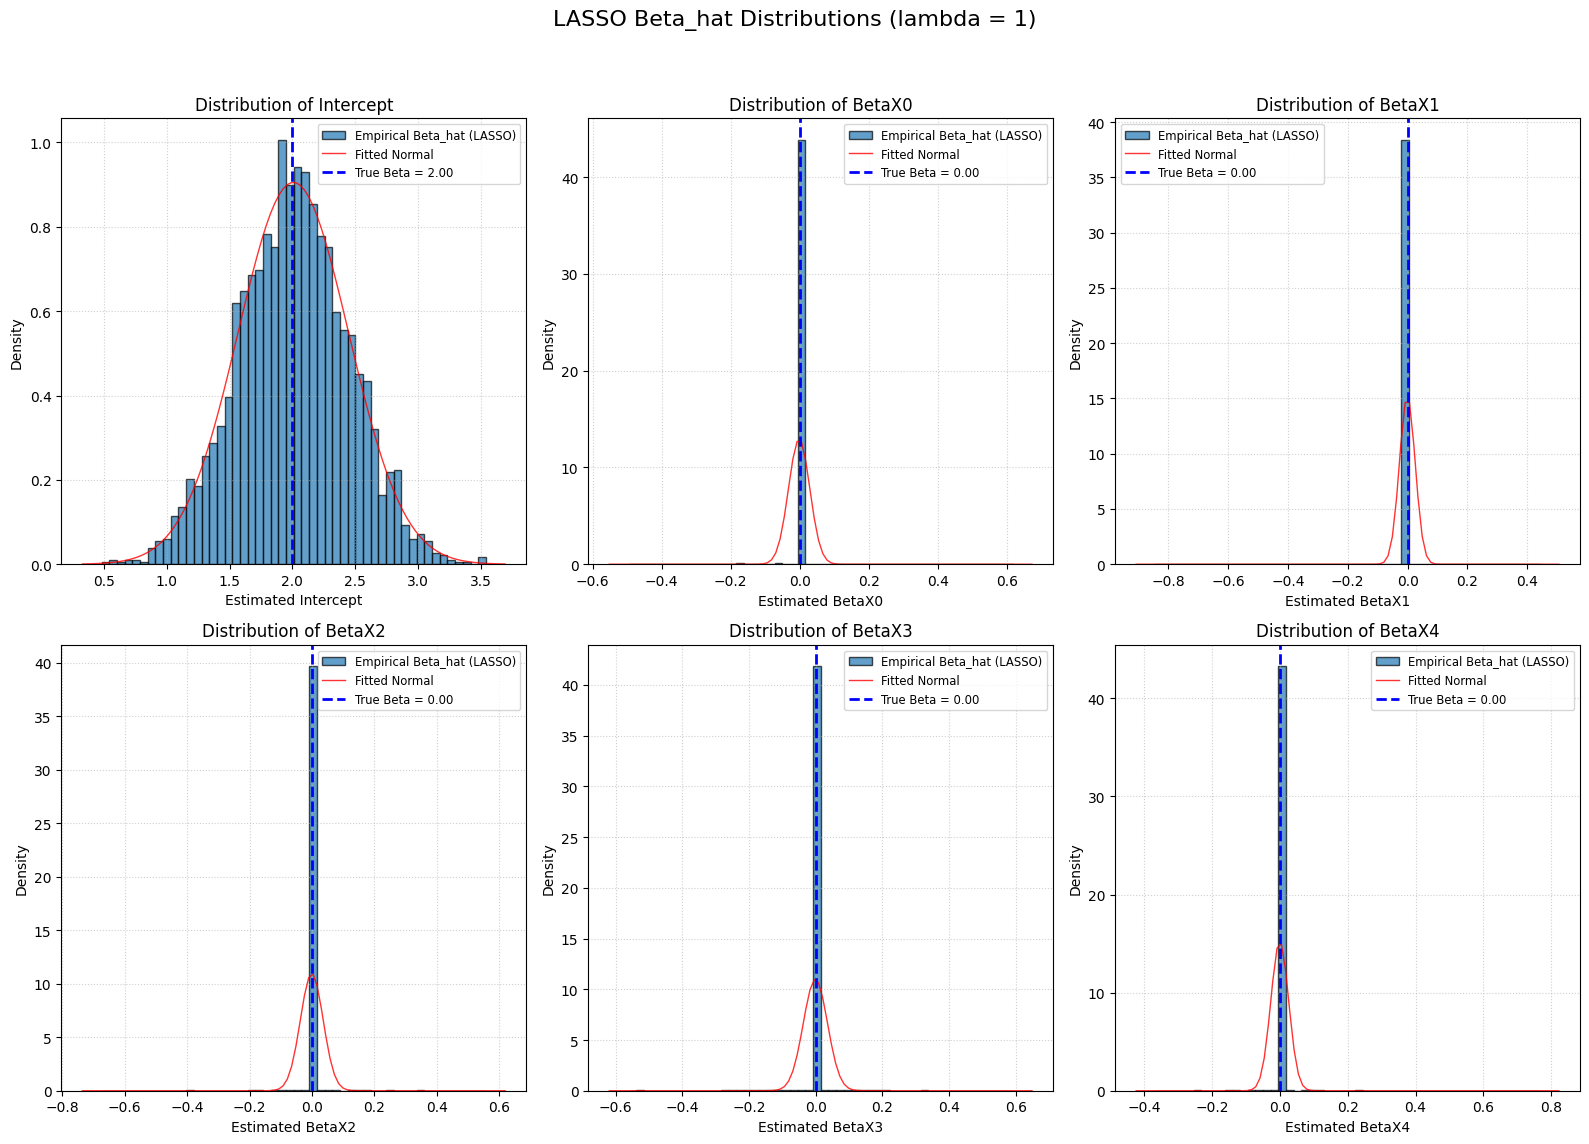

In [3]:
fig_b, axes_b = plt.subplots(2, 3, figsize=(16, 12))
axes_b = axes_b.flatten()


for idx, col_name in enumerate(columns):
    beta_values_for_hist = beta_hat_df[col_name]
    axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat (LASSO)')
    
    mu_emp, std_emp = norm.fit(beta_values_for_hist)
    xmin_hist, xmax_hist = axes_b[idx].get_xlim()
    x_norm_emp = np.linspace(xmin_hist, xmax_hist, 100)
    p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
    axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=1, alpha=0.8, label=f'Fitted Normal')

    true_val_plot = beta_true[idx]
    axes_b[idx].axvline(true_val_plot, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val_plot:.2f}')
    
    axes_b[idx].set_title(f'Distribution of {col_name}')
    axes_b[idx].set_xlabel(f'Estimated {col_name}')
    axes_b[idx].set_ylabel('Density')
    axes_b[idx].legend(fontsize='small')
    axes_b[idx].grid(True, linestyle=':', alpha=0.6)

# Ẩn các subplot không sử dụng
for i in range(len(columns), len(axes_b)):
    fig_b.delaxes(axes_b[i])

fig_b.suptitle(f"LASSO Beta_hat Distributions (lambda = {lam})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

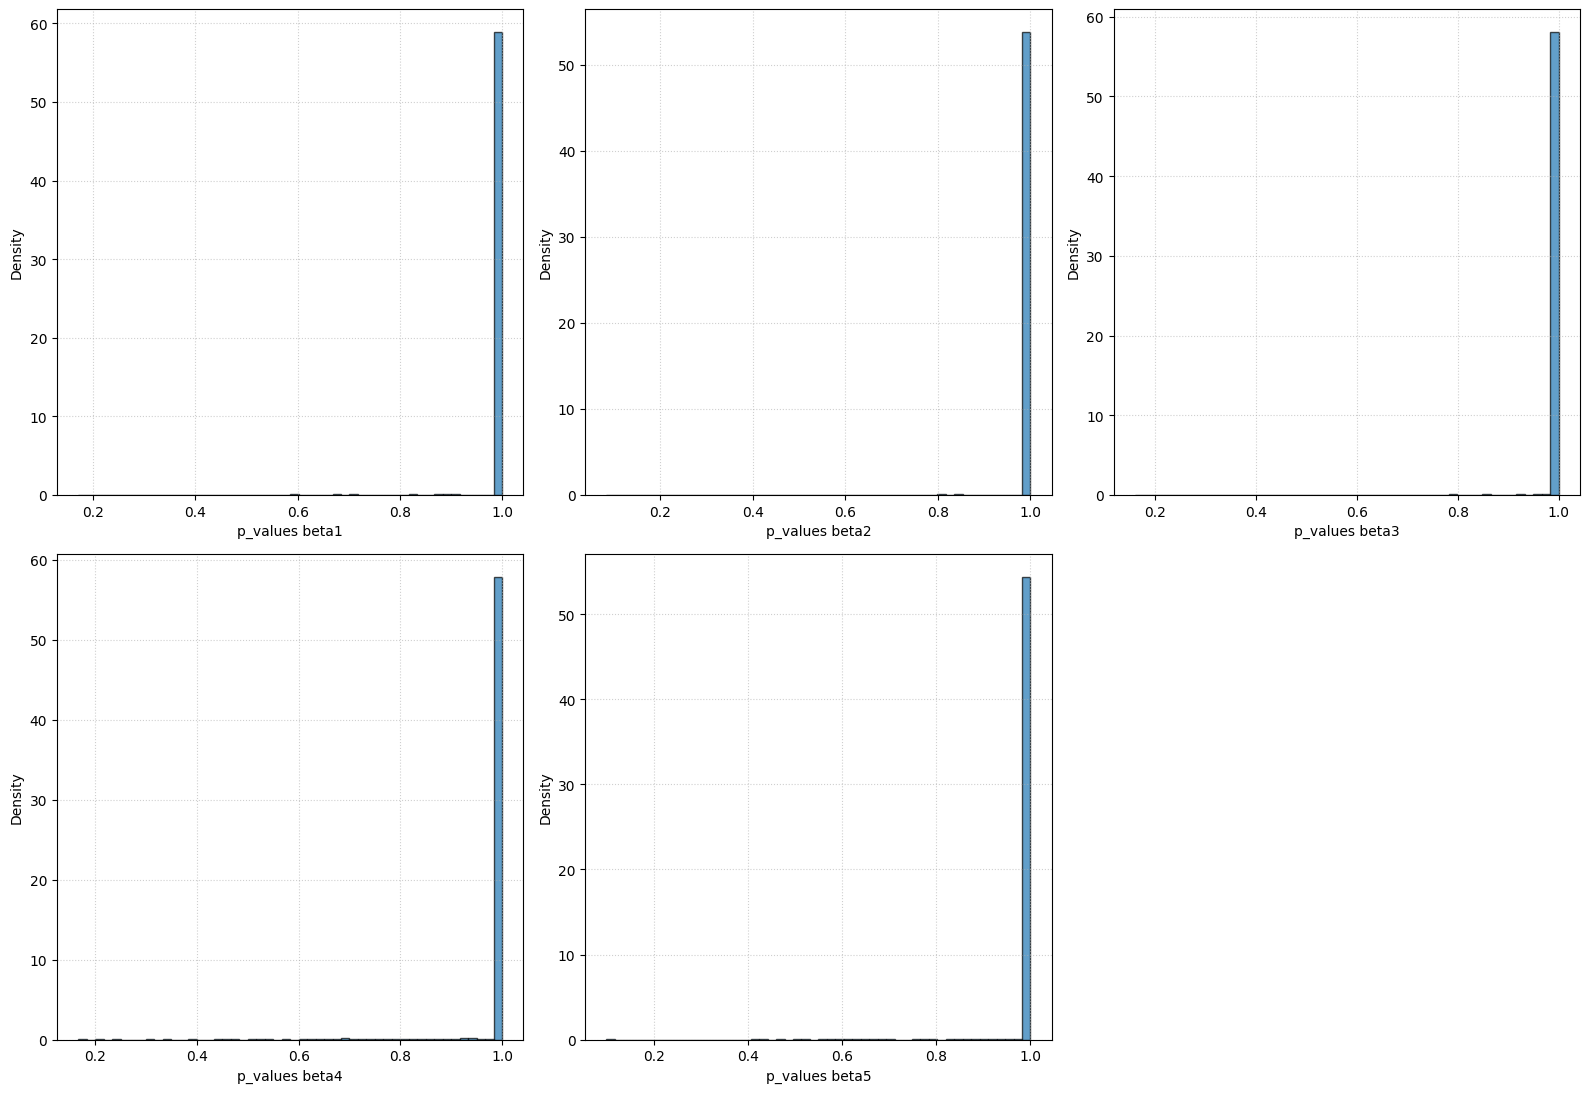

In [4]:
fig_b, axes_b = plt.subplots(2, 3, figsize = (16, 12))
axes_b = axes_b.flatten()


for idx, col_name in enumerate(p_columns):
    p_values = pvalues_df[col_name]
    axes_b[idx].hist(p_values, bins=50, density=True, edgecolor='black', alpha=0.7)
    
    axes_b[idx].set_xlabel(f'p_values beta{idx + 1}')
    axes_b[idx].set_ylabel('Density')
    axes_b[idx].grid(True, linestyle=':', alpha=0.6)


for i in range(len(p_columns) , len(axes_b)):
    fig_b.delaxes(axes_b[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
kstest(beta_hat_df['BetaX4'], 'norm', args=(np.mean(beta_hat_df['BetaX4']), np.std(beta_hat_df['BetaX4'])))


KstestResult(statistic=np.float64(0.49061185270577684), pvalue=np.float64(0.0), statistic_location=np.float64(0.0), statistic_sign=np.int8(1))